In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
import shap
from tqdm.notebook import tqdm


# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


In [64]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]-1

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(202878, 470)


In [84]:
print(dates)

0         2000-01-01 00:00:00
1         2000-01-01 01:00:00
2         2000-01-01 02:00:00
3         2000-01-01 03:00:00
4         2000-01-01 04:00:00
                 ...         
202873    2022-12-30 20:00:00
202874    2022-12-30 21:00:00
202875    2022-12-30 22:00:00
202876    2022-12-30 23:00:00
202877    2022-12-31 00:00:00
Name: Date, Length: 202878, dtype: object


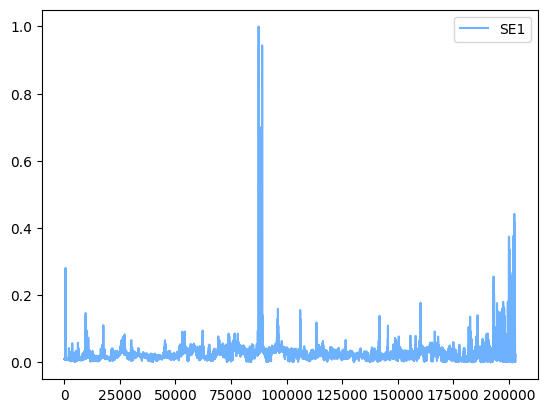

In [102]:
y = df['SE1']

plt.plot(y, color='#6db1ff', label='SE1')
plt.legend()

In [66]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 470)
(20287, 470)
(10143, 470)


In [67]:
# Define the sequence length for the LSTM model
sequence_length = 10

def create_sequences(df, sequence_length):
    X = []
    y = []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length, 1:].values)
        y.append(df.iloc[i+sequence_length, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_sequences(train_df, sequence_length)
X_val, y_val = create_sequences(val_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(172438, 10, 469)
(20277, 10, 469)
(10133, 10, 469)


In [68]:
batch_size = 128
print(y_val.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train, :, :]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val, :, :]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test, :, :]
y_test = y_test[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(20277,)


(172416,)


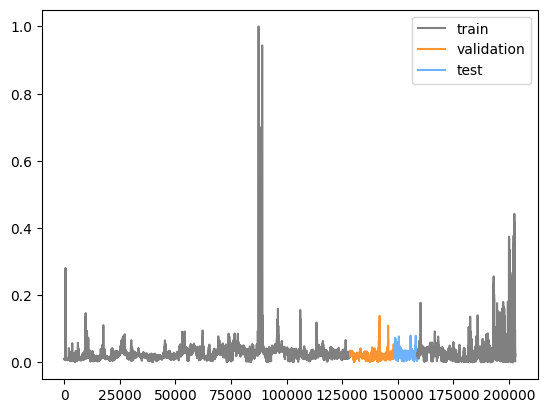

In [69]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey', label='train')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='#fc9432', label='validation')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='#6db1ff', label='test')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')
plt.legend()

In [70]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, sequence_length, n_features), return_sequences=True, stateful=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Normalization(),
    tf.keras.layers.LSTM(32, batch_input_shape=(batch_size, sequence_length, n_features), stateful=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


In [71]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color='grey')
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color='#6db1ff')
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [72]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping, PlotLearning()])
  return history

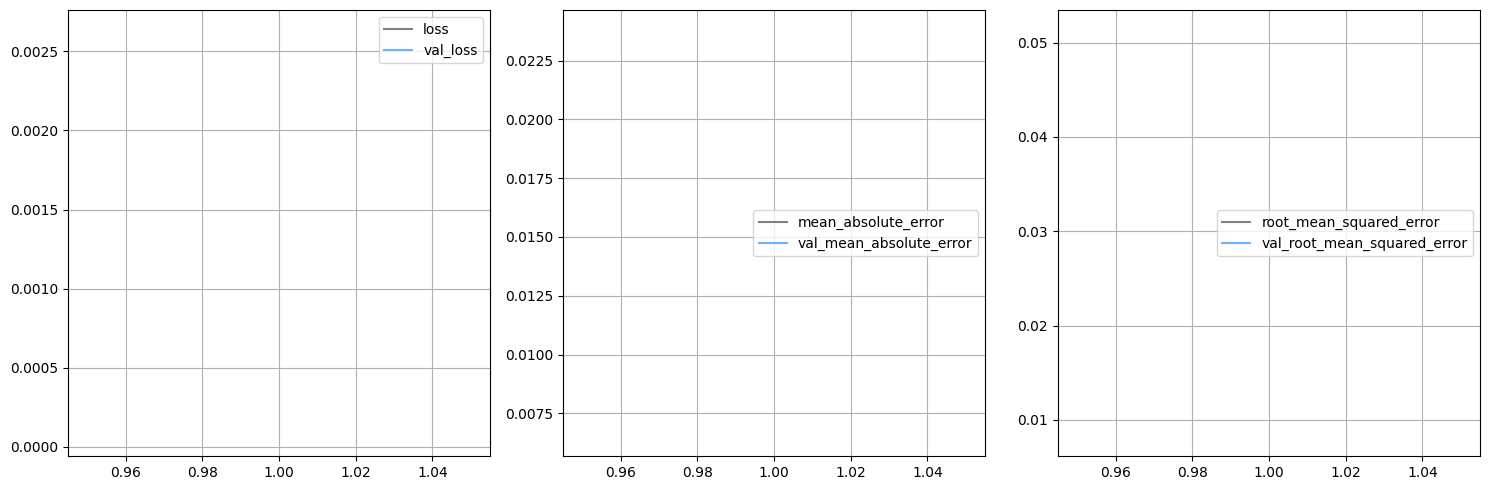

1347/1347 [==============================] - 99s 69ms/step - loss: 0.0026 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0513 - val_loss: 6.8897e-05 - val_mean_absolute_error: 0.0065 - val_root_mean_squared_error: 0.0083
Epoch 2/10
1322/1347 [============================>.] - ETA: 1s - loss: 1.6783e-04 - mean_absolute_error: 0.0071 - root_mean_squared_error: 0.0130

KeyboardInterrupt: 

In [103]:

history = compile_and_fit(model, X_train, y_train)


In [ ]:
result = model.predict(X_test, batch_size=batch_size)

79/79 [==============================] - 2s 12ms/step


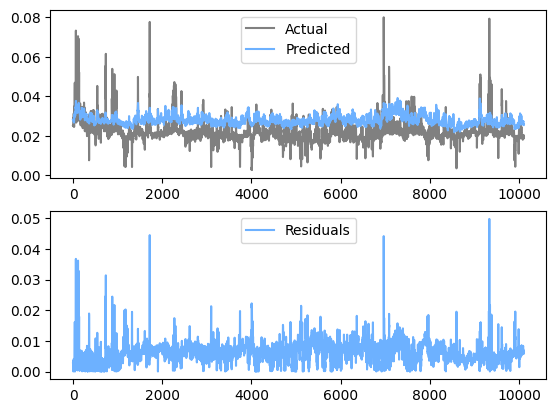

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(y_test, label='Actual', color='grey')
ax1.plot(result, label='Predicted', color='#6db1ff')
residuals = abs(np.subtract(np.array(result[:,0]), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color='#6db1ff')
ax2.legend()

In [ ]:
COLS = list(df.columns[1:])
n_cols = len(COLS)
# n_cols = 5
# results = []
print('Computing LSTM feature importance...')

# COMPUTE BASELINE (NO SHUFFLE)
oof_preds = model.predict(X_val, verbose=0, batch_size=batch_size).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-y_val ))
# results.append({'feature':'BASELINE','mae':baseline_mae})           
fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
fi_df.to_csv('feature_importance.csv', index=False, header=False)
for k in range(n_cols):
    # SHUFFLE FEATURE K
    save_col = X_val[:,:,k].copy()
    X_val[:,:,k] = np.zeros((X_val.shape[0],X_val.shape[1]))
            
    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = model.predict(X_val, verbose=0, batch_size=batch_size).squeeze() 
    mae = np.mean(np.abs( oof_preds-y_val ))
    # results.append({'feature':COLS[k],'mae':mae})
    fi_df = pd.DataFrame([COLS[k], mae]).T
    fi_df.to_csv('feature_importance.csv', mode='a', index=False, header=False)
    X_val[:,:,k] = save_col


Computing LSTM feature importance...



0.0001687968786140256
83                                 NO3_DK1A
443               SE_wind_offshore_capacity
11            Bioenergy and renewable waste
102                                  FI_SE1
32                 Renewable energy sources
75                                   DK2_KT
349                               SE1_RN_PR
10                            Import/Export
90                                   EE_ELE
6                          Summa Värmekraft
322                                SE_RN_PR
273                              EE_LV_D_FE
29      Other bioenergy and renewable waste
431                          SE_temperature
4                         Summa Vattenkraft
111                                 SE1_SE2
42                                  NO1_NO2
26                                 Offshore
166                            SE3_DK1A+NO1
69                                 SEA_DK1A
429    SE_4_load_actual_entsoe_transparency
216                            NO4_NO3_D_FE
101      

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000021902B45790>
Traceback (most recent call last):
  File "c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\weakref.py", line 368, in remove
    self = selfref()
KeyboardInterrupt: 


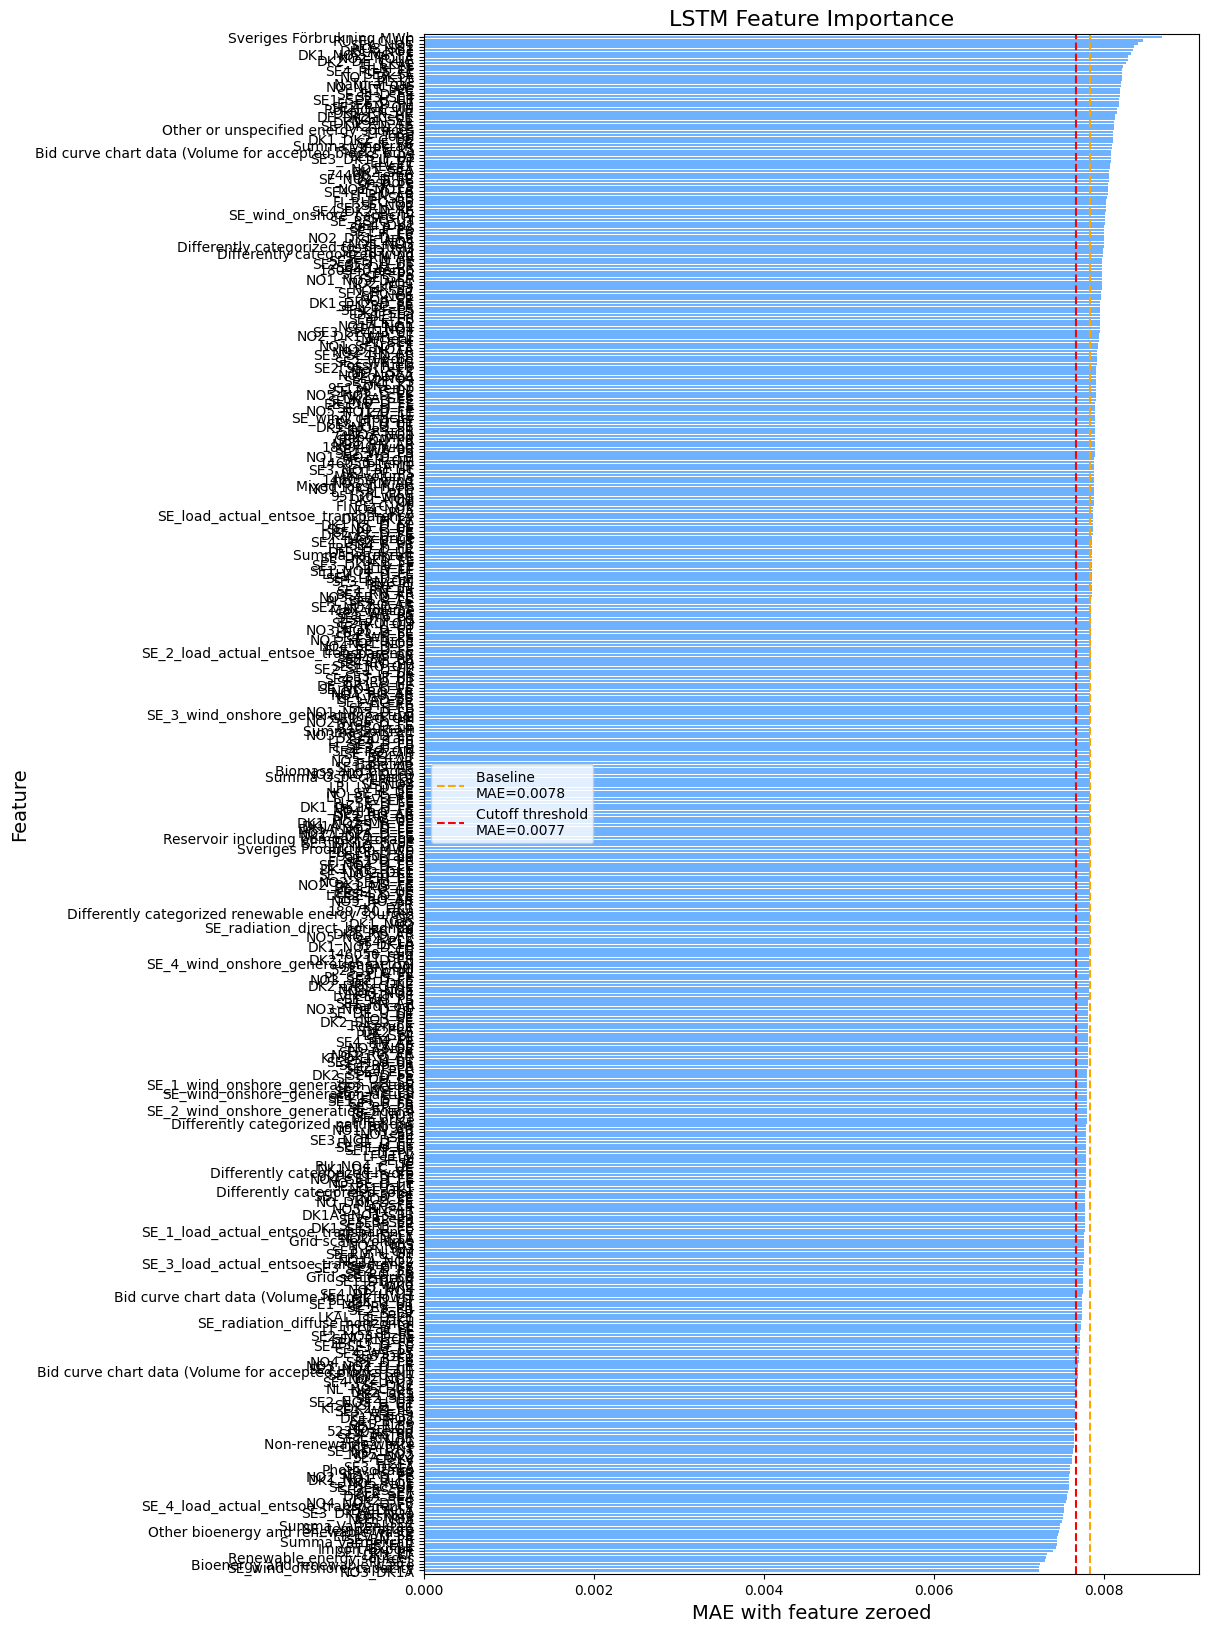

In [129]:

# DISPLAY LSTM FEATURE IMPORTANCE
print()
df2 = pd.read_csv('feature_importance.csv', header=None, names=['feature','mae'])
df2 = df2.sort_values('mae')

cutoff = np.std(df2).mae
print(cutoff)
drop_columns = df2[df2['mae'] < baseline_mae - cutoff].feature
print(drop_columns.shape)
print(df2[df2['mae'] < baseline_mae - cutoff].shape[0])

plt.figure(figsize=(10,20))
plt.barh(np.arange(n_cols+1),df2.mae, color='#6db1ff')
plt.yticks(np.arange(n_cols+1),df2.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,n_cols+1))

plt.plot([baseline_mae,baseline_mae],[-1,n_cols+1], '--', color='orange',
            label=f'Baseline \nMAE={baseline_mae:.4f}')
plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color='red',
            label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

plt.xlabel(f'MAE with feature zeroed',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [ ]:
# features = df.columns
# # Create a batch of data with the expected batch size
# n_samples = batch_size * (len(X_train) // batch_size)
# X_batch = X_train[:n_samples]
# X_batch = X_batch[np.random.choice(X_batch.shape[0], batch_size, replace=False)]

# # Create an instance of the DeepExplainer class
# explainer = shap.DeepExplainer(model, data=X_batch)

# # Select a subset of X_test and calculate SHAP values for that subset
# n_samples = 128 # You may need to adjust this number depending on your system's resources
# X_test_subset = X_test[:n_samples]
# shap_values = explainer.shap_values(X_test_subset)

# # Select a single instance to display the SHAP values for
# idx = 0
# instance = X_test_subset[idx]
# shap.force_plot(explainer.expected_value[0], shap_values[0][idx], instance, features)

ValueError: in user code:

    File "c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected shape=(128, None, 469), found shape=(256, 10, 469)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=['tf.Tensor(shape=(256, 10, 469), dtype=float32)']
      • training=False
      • mask=None
